In [1]:
import matplotlib.pyplot as plt
import numpy as np
%config InlineBackend.figure_format = 'retina'

In [70]:
u_upper = 1
u_lower = 1

s_w = 174         # wing area (ft^2)
s_w = 161.5       # wing area (ft^2)
a_w = 7.32        # wing aspect ratio
a_w = 7           # wing aspect ratio
n_max = 3.8 * 1.5 * np.random.uniform(u_lower, u_upper)# maximum load (g)                       THIS IS A GUESS

s_h = 36.6 * np.random.uniform(u_lower, u_upper)       # horizontal tail area (ft^2)            THIS IS A GUESS
a_h = 3.5 * np.random.uniform(u_lower, u_upper)        # horizontal tail aspect ratio           THIS IS A GUESS
a_h = 5 * np.random.uniform(u_lower, u_upper)          # horizontal tail aspect ratio           CHANGED
t_rh = 0.2 * np.random.uniform(u_lower, u_upper)       # maximum root thickness (ft)            MASSIVE FUCKIN GUESS

s_v = 21.5 * np.random.uniform(u_lower, u_upper)       # vertical tail area (ft^2)              THIS IS A GUESS
a_v = 1 * np.random.uniform(u_lower, u_upper)          # vertical tail aspect ratio             THIS IS A GUESS
t_rv = 0.5 * np.random.uniform(u_lower, u_upper)       # max vertical tail root thickness (ft)  THIS IS A GUESS
lambda_q = 10 * np.random.uniform(u_lower, u_upper)    # quater chord sweep angle (degrees)     THIS IS A GUESS

l_fn = 19 * np.random.uniform(u_lower, u_upper)        # length from firewall of fuesalage (ft) PRETTY SURE
p_max = 180      # maximum power (HP)
n_pax = 4       # number of people onboard

k_n = 0.24       # nacelle constant

w_l = 2550        # landing weight (lbs)
n_ult_l = 5.7     # ultimate landing force
l_sm = 0          # main strut length (ft)                  THIS MAY NEED TO BE NON-ZERO
l_sn = 5/12 * np.random.uniform(u_lower, u_upper)      # nose strut length (ft)

k_p = 1.1         # propulsion constant
p_to = p_max        # power at takeoff (HP)                   THIS MAY BE WRONG

w_f = 55 * 6.01 * np.random.uniform(u_lower, u_upper)  # fuel weight(lbs)                        THIS MAY BE WRONG

In [71]:
def wing(S_w, A_w, N):
    s = np.power(S_w, 1.018)
    a = np.power(A_w, 2.473)
    n = np.power(N, 0.611)
    return 0.00293* s * a * n

def horizontal(W_to, S_h, A_h, T_rn):
    w = np.power(W_to, 0.887)
    s = np.power(S_h, 0.101)
    a = np.power(A_h, 0.138)
    t = np.power(T_rn, 0.223)
    return (3.184 * w * s * a)/(57.5 * t)

def vertical(W_to, S_v, A_v, t_rv, Lambda_q):
    w = np.power(W_to, 0.567)
    s = np.power(S_v, 1.249)
    a = np.power(A_v, 0.482)
    t = np.power(t_rv, 0.747)
    l = np.power(np.cos(np.radians(Lambda_q)), 0.882)
    return (1.68 * w * s * a)/(15.6 * t * l)

def fueselage(W_to, L_fn, P_max, N_pax):
    w = np.power(W_to, 0.144)
    p = np.power(L_fn/P_max, 0.778)
    l = np.power(L_fn, 0.383)
    n = np.power(N_pax, 0.455)
    return 14.68 * w * p * l * n

def nacelle(W_to, k_n = 0.24):
    return W_to * k_n

def gear(W_to, W_l, L_sm, L_sn, N_ultl=5.7):
    wl_m = np.power(W_l, 0.417)
    n_m = np.power(N_ultl, 0.95)
    l_m = np.power(L_sm, 0.183)
    
    wl_n = np.power(W_l, 0.749)
    nl = np.power(L_sn * N_ultl, 0.788)
    
    return 0.013 * W_to + 0.146 * wl_m * n_m * l_m + 6.2 + 0.0013 * W_to + 0.000143 * wl_n * nl

def engine(P_to, k_p = 1.1):
    return k_p * P_to

def fuel_system(W_f, k_fsp = 5.87):
    return 0.4 * W_f / k_fsp

def propulsion():
    return 268

def controls(W_to):
    return 0.0168 * W_to

def electric(W_to):
    return 0.0268 * W_to

def furnishings(W_to, N_pax):
    w = np.power(W_to, 0.0489)
    n = np.power(N_pax, 1.145)
    return 0.412 * n * w

def paint(W_to):
    return 0.003 - 0.006 * W_to

In [72]:
def full_weight(W_to):
    aero = wing(s_w, a_w, n_max) + horizontal(W_to, s_h, a_h, t_rh) + vertical(W_to, s_v, a_v, t_rv, lambda_q)
    outside = fueselage(W_to, l_fn, p_max, n_pax) + gear(W_to, w_l, l_sm, l_sn)
    prime_mover = nacelle(W_to) + engine(p_to) + fuel_system(w_f)
    the_rest = propulsion() + controls(W_to) + furnishings(W_to, n_pax)
    struct = aero + outside + prime_mover + the_rest
    
    struct +=  electric(W_to)
        
    return struct

In [73]:
ws = [0]
for i in range(75):
    ws.append(full_weight(ws[-1]))

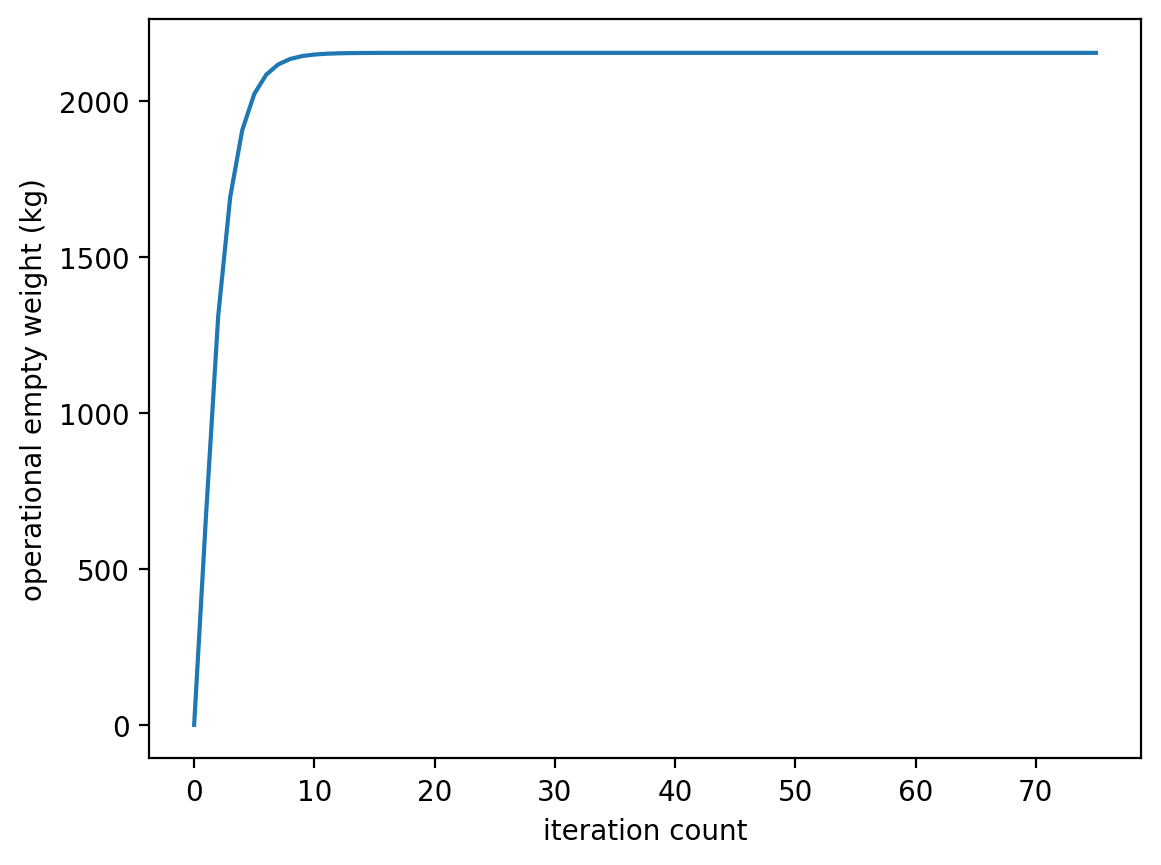

In [74]:
plt.plot(ws)
plt.xlabel("iteration count")
plt.ylabel("operational empty weight (kg)")
plt.savefig("oew-conv.png")

/var/folders/nw/qn2qj07s7qq860r608rn78hm0000gn/T/ipykernel_21293/535394271.py:1: RuntimeWarning: divide by zero encountered in log
  plt.plot(np.log(np.gradient(ws)))


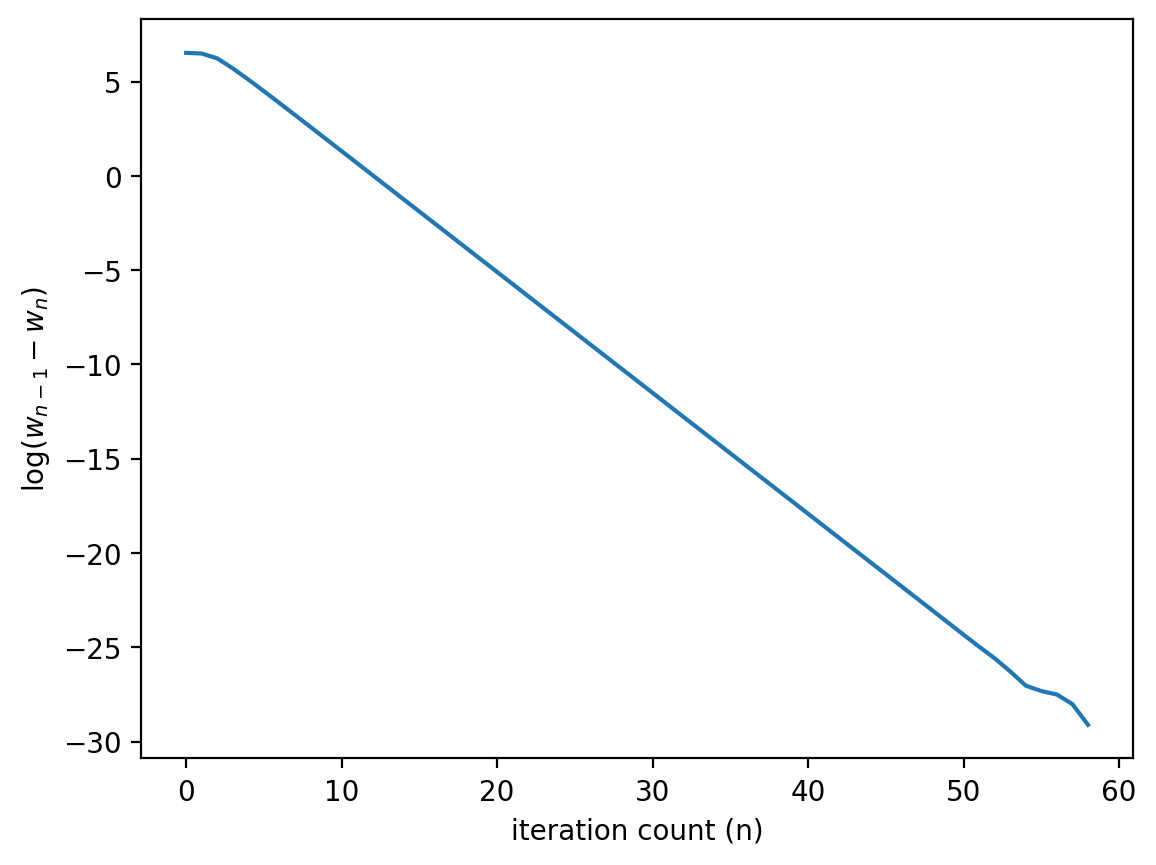

In [75]:
plt.plot(np.log(np.gradient(ws)))
plt.xlabel("iteration count (n)")
plt.ylabel("$\log(w_{n-1} - w_{n})$")
plt.savefig("residual-oew.png")

In [76]:
ws[-1]

2154.0996941855524

originanlly 2220

In [77]:
'''lotsa = []
for j in range(1000):
    ws = [1e-6]
    for i in range(100):
        ws.append(full_weight(ws[-1]))
    lotsa.append(ws[-1])
    u_upper = 0.9
    u_lower = 1.1

    s_w = 174         # wing area (ft^2)
    a_w = 7.32        # wing aspect ratio
    n_max = 3.8 * 1.5 * np.random.uniform(u_lower, u_upper)# maximum load (g)                       THIS IS A GUESS

    s_h = 36.6 * np.random.uniform(u_lower, u_upper)       # horizontal tail area (ft^2)            THIS IS A GUESS
    a_h = 3.5 * np.random.uniform(u_lower, u_upper)        # horizontal tail aspect ratio           THIS IS A GUESS
    t_rh = 0.2 * np.random.uniform(u_lower, u_upper)       # maximum root thickness (ft)            MASSIVE FUCKIN GUESS

    s_v = 21.5 * np.random.uniform(u_lower, u_upper)       # vertical tail area (ft^2)              THIS IS A GUESS
    a_v = 1 * np.random.uniform(u_lower, u_upper)          # vertical tail aspect ratio             THIS IS A GUESS
    t_rv = 0.5 * np.random.uniform(u_lower, u_upper)       # max vertical tail root thickness (ft)  THIS IS A GUESS
    lambda_q = 10 * np.random.uniform(u_lower, u_upper)    # quater chord sweep angle (degrees)     THIS IS A GUESS

    l_fn = 19 * np.random.uniform(u_lower, u_upper)        # length from firewall of fuesalage (ft) PRETTY SURE
    p_max = 180      # maximum power (HP)
    n_pax = 4       # number of people onboard

    k_n = 0.24       # nacelle constant

    w_l = 2550        # landing weight (lbs)
    n_ult_l = 5.7     # ultimate landing force
    l_sm = 0          # main strut length (ft)                  THIS MAY NEED TO BE NON-ZERO
    l_sn = 5/12 * np.random.uniform(u_lower, u_upper)      # nose strut length (ft)

    k_p = 1.1         # propulsion constant
    p_to = p_max        # power at takeoff (HP)                   THIS MAY BE WRONG

    w_f = 55 * 6.01 * np.random.uniform(u_lower, u_upper)  # fuel weight(lbs)                        THIS MAY BE WRONG
'''

'lotsa = []\nfor j in range(1000):\n    ws = [1e-6]\n    for i in range(100):\n        ws.append(full_weight(ws[-1]))\n    lotsa.append(ws[-1])\n    u_upper = 0.9\n    u_lower = 1.1\n\n    s_w = 174         # wing area (ft^2)\n    a_w = 7.32        # wing aspect ratio\n    n_max = 3.8 * 1.5 * np.random.uniform(u_lower, u_upper)# maximum load (g)                       THIS IS A GUESS\n\n    s_h = 36.6 * np.random.uniform(u_lower, u_upper)       # horizontal tail area (ft^2)            THIS IS A GUESS\n    a_h = 3.5 * np.random.uniform(u_lower, u_upper)        # horizontal tail aspect ratio           THIS IS A GUESS\n    t_rh = 0.2 * np.random.uniform(u_lower, u_upper)       # maximum root thickness (ft)            MASSIVE FUCKIN GUESS\n\n    s_v = 21.5 * np.random.uniform(u_lower, u_upper)       # vertical tail area (ft^2)              THIS IS A GUESS\n    a_v = 1 * np.random.uniform(u_lower, u_upper)          # vertical tail aspect ratio             THIS IS A GUESS\n    t_rv = 0.5 * np

In [78]:
'''
plt.hist(np.array(lotsa), density = True, bins = 500)
plt.ylabel("probability density")
plt.xlabel("weight ($lbs$)")
'''

'\nplt.hist(np.array(lotsa), density = True, bins = 500)\nplt.ylabel("probability density")\nplt.xlabel("weight ($lbs$)")\n'

In [79]:
eta_p = 0.8
bsfc = 0.0015
woe = ws[-1] * 0.453592
wfr = 6.7 * 6.01 * 0.453592 # reserve fuel
kc = 0.95 # fraction of fuel left at start of cruise
eta_p = 0.8

def clld(cl):
    turn = 0.4
    return np.where(cl <= turn, cl*60, cl) + np.where(cl > turn, 27 - 9*cl, cl)

def b_range(ld, w1, w2):
    return (eta_p/(bsfc)) * ld * np.log(w1/w2)

wfs = [50]
ranges = []
lds = []
cls = []
rho = 0.948
v = 45
range_real = 525


for i in range(10):
    wf = max(wfs[-1], 1)
    cruise_end = wfr + woe
    cruise_start = (wf * kc) + woe + wfr
    cruise_mid = (cruise_start + cruise_end) / 2
    
    cl = (2 * cruise_mid * 9.81) / (rho * v * v * 16.17)
    ld = clld(cl)
    
    range_n = b_range(ld, cruise_start, cruise_end)
    correctness = range_real/range_n
    ranges.append(range_n)
    wfs.append(wf * correctness)
    cls.append(cl)
    lds.append(ld)

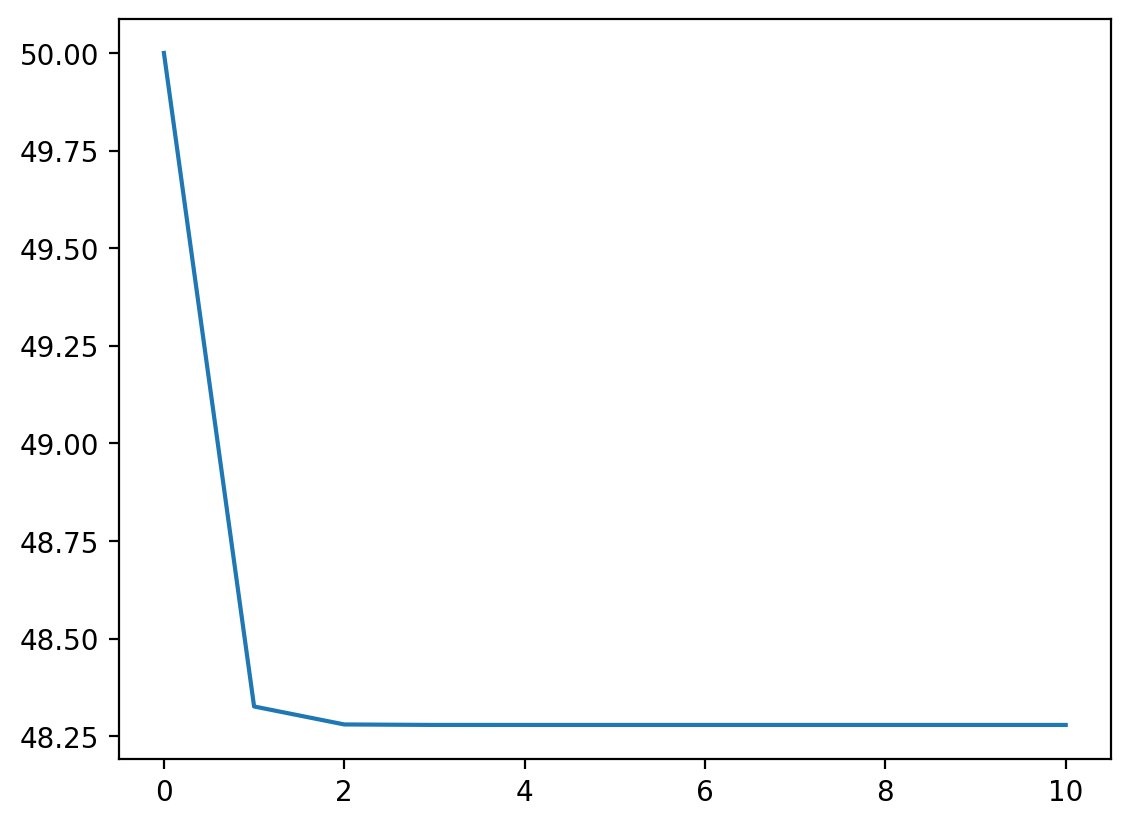

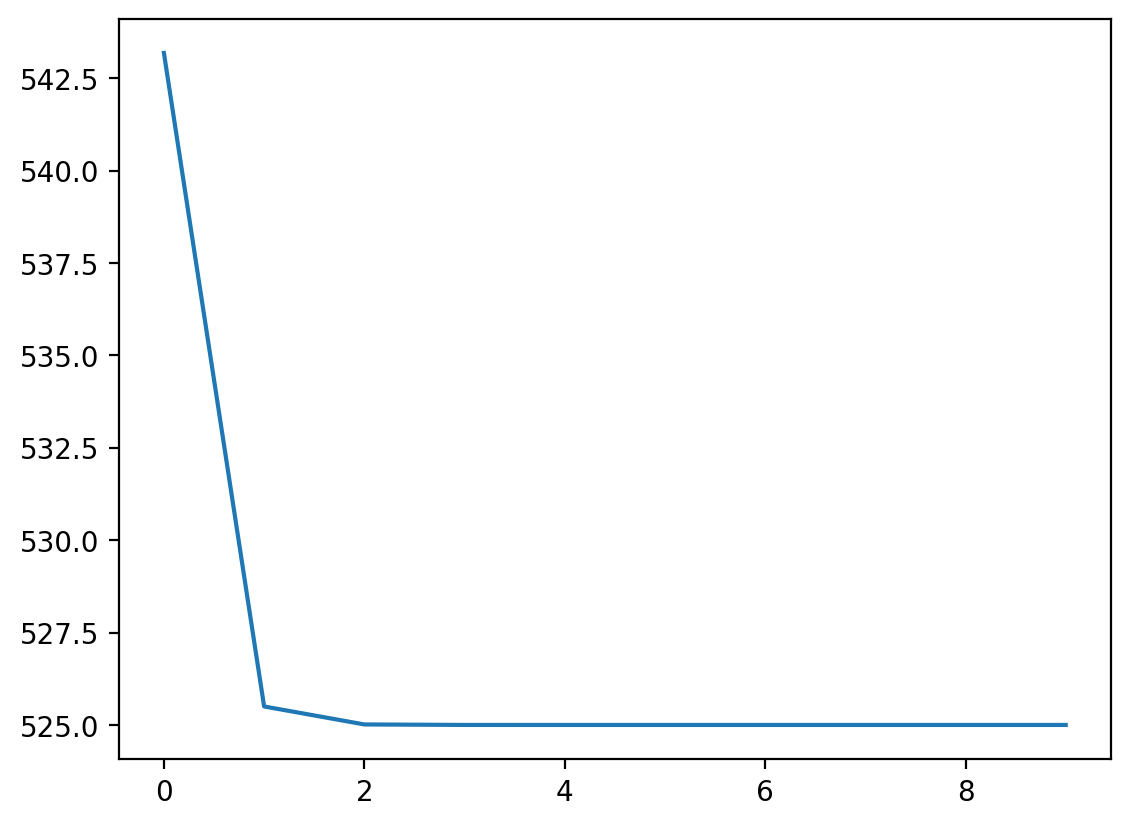

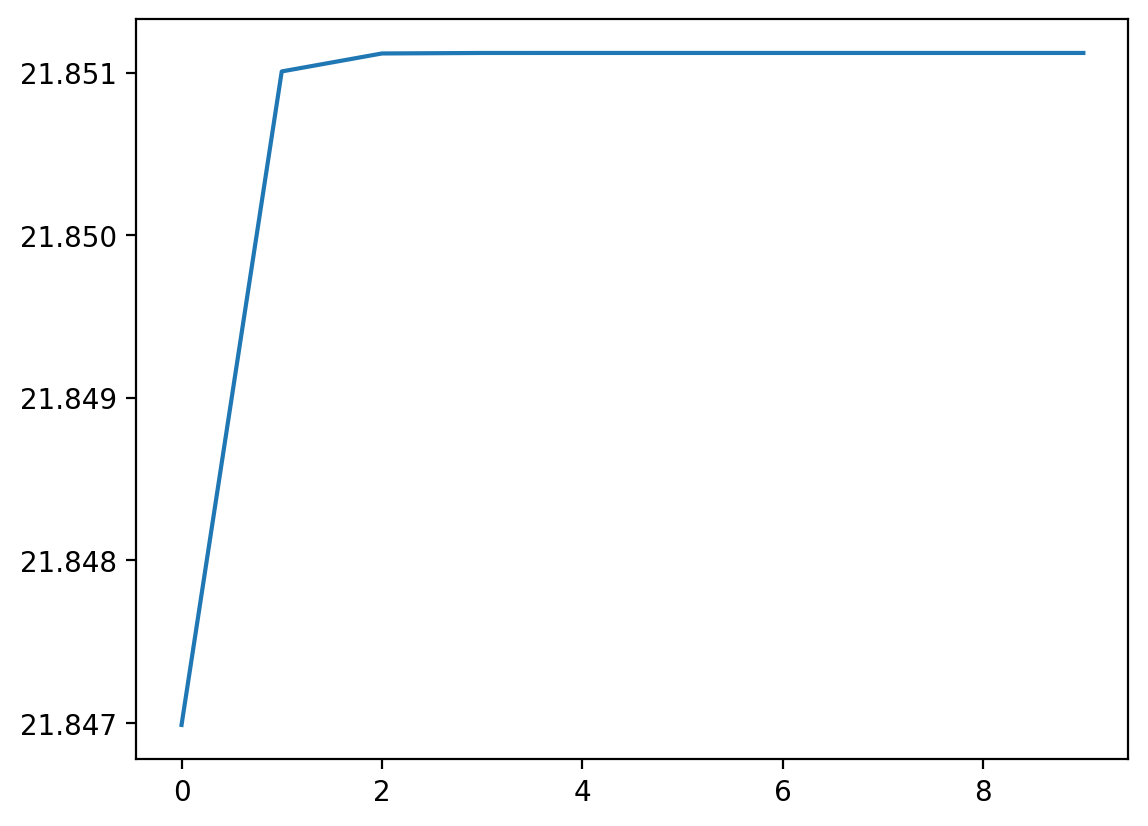

In [80]:
plt.plot(wfs)
plt.figure()
plt.plot(ranges)
plt.figure()
plt.plot(lds)

In [81]:
wfs

[50,
 48.32616890321238,
 48.280144866850655,
 48.278879353939246,
 48.27884455638652,
 48.27884359956551,
 48.27884357325578,
 48.278843572532494,
 48.27884357251263,
 48.27884357251198,
 48.27884357251178]

original wf: 157.6

In [82]:
lds

[21.846987404266034,
 21.851007633773655,
 21.851118174908535,
 21.851121214434066,
 21.851121298011286,
 21.85112130030939,
 21.851121300372583,
 21.851121300374317,
 21.85112130037437,
 21.85112130037437]

In [83]:
woe

977.0823884850131

In [84]:
wfr

18.264789064000002

In [85]:
woe + wfs[-1]

1025.3612320575248